In [1]:
import sys
sys.path.append("/home/gerald/Documents/repository/LifelongInformationRetrieval") # go to parent dir

In [2]:
import torch
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn 
from torch import optim
from lire.function_tools import gradient_tools
from lire.continual_models import ewc

In [3]:
n_tasks = 3
dataset = torchvision.datasets.MNIST

training_data = dataset("../data", train=True, download=True)
testing_data = dataset("../data", train=False, download=True)

class Permutation:

    def __init__(self, input_size):
        self.permutation_value = torch.randperm(input_size)
    def __call__(self, x):
        return x[self.permutation_value]


task_transformation = [torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,)),
                               lambda x : x.view(-1)])]
for task_index in range(n_tasks-1):
    task_transformation.append(torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,)),
                               lambda x : x.view(-1),
                               Permutation(784)]))




In [4]:
encoder_1 = nn.Linear(784, 400)
encoder_2 = nn.Linear(400, 400)
classifier = nn.Linear(400, 10)
model = nn.Sequential(encoder_1, nn.ReLU(), encoder_2, nn.ReLU(), classifier)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-2)

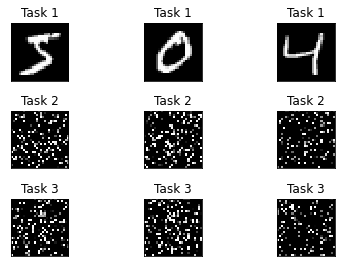

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()

for task_index, task_transform in enumerate(task_transformation):
    training_data = dataset("../data", train=True, transform=task_transform)
    for i in range(3):
        plt.subplot(3,3, task_index * 3 + i + 1)
        plt.tight_layout()
        plt.imshow(training_data[i][0].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Task "+str(task_index+1))
        plt.xticks([])
        plt.yticks([])       


In [6]:
epoch = 10
log = {str(i): {"x" : [], "y" : []} for i in range(len(task_transformation))}
for task_index, task_transform in enumerate(task_transformation):
    print("loading task ", task_index)
    training_data = dataset("../data", train=True, transform=task_transform)
    print("\t create dataloader")
    dataloader = torch.utils.data.DataLoader(training_data, batch_size=1024, shuffle=True, num_workers=2)

    for v in range(epoch):
        print(v)
        for task_index_test in range(0, task_index+1):
            with torch.no_grad():
                testing_data = dataset("../data", train=False, transform=task_transformation[task_index_test])
                dataloader_test = torch.utils.data.DataLoader(testing_data, batch_size=500, shuffle=True, num_workers=2)
                classification_score = 0.
                for x, y in dataloader_test:
                    y_pred = model(x)
                    _, index = y_pred.max(-1)
                    classification_score += (index == y.squeeze()).sum()

                log[str(task_index_test)]["x"].append(task_index * epoch + v)
                log[str(task_index_test)]["y"].append(classification_score/len(dataloader_test.dataset) )
    
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y.squeeze())
            
            loss.backward()
            optimizer.step()

loading task  0
	 create dataloader
0
1
2
3
4
5
6
7
8
9
loading task  1
	 create dataloader
0
1
2
3
4
5
6
7
8
9
loading task  2
	 create dataloader
0
1
2
3
4
5
6
7
8
9


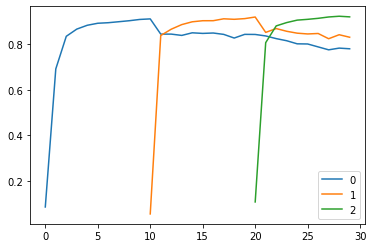

In [7]:
from matplotlib import pyplot as pyplot

for name, data in log.items():
    plt.plot(data["x"], data["y"], label=name)
plt.legend()

In [8]:

class LogProbModel(nn.Module):
    def __init__(self, model, criterion):
        super(LogProbModel, self).__init__()
        self.model = model
        self.criterion = criterion
    
    def forward(self, data):
        x, y = data
        y_pred = self.model(x.unsqueeze(0))
        log_prob = self.criterion(y_pred, torch.LongTensor([y]))
        return log_prob

log_prob_model = LogProbModel(model, criterion)
ewc_model = ewc.EWC(log_prob_model)
epoch = 10
log_ewc = {str(i): {"x" : [], "y" : []} for i in range(len(task_transformation))}
for task_index, task_transform in enumerate(task_transformation):
    if(task_index > 0):
        ewc_model.next_task(training_data, log_prob_model)
    print("loading task ", task_index)
    training_data = dataset("../data", train=True, transform=task_transform)
    print("\t create dataloader")
    dataloader = torch.utils.data.DataLoader(training_data, batch_size=1024, shuffle=True, num_workers=2)

    for v in range(epoch):
        print(v)
        for task_index_test in range(0, task_index+1):
            with torch.no_grad():
                testing_data = dataset("../data", train=False, transform=task_transformation[task_index_test])
                dataloader_test = torch.utils.data.DataLoader(testing_data, batch_size=500, shuffle=True, num_workers=2)
                classification_score = 0.
                for x, y in dataloader_test:
                    y_pred = model(x)
                    _, index = y_pred.max(-1)
                    classification_score += (index == y.squeeze()).sum()

                log_ewc[str(task_index_test)]["x"].append(task_index * epoch + v)
                log_ewc[str(task_index_test)]["y"].append(classification_score/len(dataloader_test.dataset) )
    
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y.squeeze())
            if(task_index > 0):
                loss += 1. *  ewc_model.ewc_loss()
            loss.backward()
            optimizer.step()

loading task  0
	 create dataloader
0
1
2
3
4
5
6
7
8
9
loading task  1
	 create dataloader
0
1
2
3
4
5
6
7
8
9
loading task  2
	 create dataloader
0
1
2
3
4
5
6
7
8
9


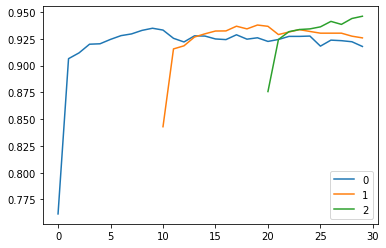

In [11]:
from matplotlib import pyplot as pyplot

for name, data in log_ewc.items():
    plt.plot(data["x"], data["y"], label=name)
plt.legend()